In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install --upgrade --no-cache-dir gdown
!pip install contractions
!gdown --id 1LlEA3Z0X6SA11KK6CHVugUuDRF8H1wDS # utils Bimpm
!gdown --id 1O_35Y7yhCvNvzo48OAUJ8tbJJyn8tiSI # dataset Bimpm
!gdown --id 138Xn0CtAs6BDQ0TXFzWnkDA4Ij2p5kdH # network Bimpm
!gdown --id 1XfV8pVN39Rwl--2wI2rQ1paZSV4N1VsY #Glove
!gdown --id 1yVfLxAPubn-b4ZWnKX9-lvnXT6OzmGCt #text free images
!gdown --id 1cQnxpWJwSUitkzX5mOiNpuF33poY2mR- #Annotation File
!gdown --id 1YYrS-uDP71m373ldBNIONAO4xZhiPuny  #resne152.pth

In [ ]:
#Load necessary files
from dataset_bimpm_multi import *
from network_bimpm_multi import myResnet, MMIAN, resnet152
from utils_bimpm_multi import load_model, save_model, score, embedding

In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch import cuda, dropout 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
!unzip annotation_file.zip
!unzip Glove.zip
!unzip text_free_images.zip

In [ ]:
!mv text_free_images  Images
!ls

annotation_file		Images			sample_data
annotation_file.zip	__MACOSX		text_free_images.zip
dataset_bimpm_multi.py	network_bimpm_multi.py	utils_bimpm_multi.py
Glove			__pycache__
Glove.zip		resnet152.pth


In [ ]:
metric_df = pd.DataFrame(columns = ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy', 'Train Weighted F1', 'Validation Weighted F1', 'Train Macro F1', 'Validation Macro F1'])

Creating Dataloder for train and validation

In [ ]:
roletolabel = {'hero' : 0, 'villain' : 1, 'victim' : 2, 'other' : 3}
path = "/content/Glove/glove.6B.100d.txt"
vocab , embeddings_np = embedding(path)

In [ ]:
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [ ]:
train_dataset = Custom(r"/content/Images", r"/content/annotation_file/train.csv", vocab, transform, freq_threshold = 3, roletolabel = roletolabel)
pad_idx = train_dataset.vocab.stoi["<PAD>"]

In [ ]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, num_workers = 0, shuffle=True, pin_memory=True, 
                    collate_fn = MyCollate(pad_idx = pad_idx), drop_last = False)

In [ ]:
val_dataset = Custom(r"/content/Images", r"/content/annotation_file/val.csv", vocab, transform, freq_threshold = 3, roletolabel = roletolabel)
pad_idx = val_dataset.vocab.stoi["<PAD>"]

In [ ]:
val_loader = DataLoader(dataset = val_dataset, batch_size = 32, num_workers = 0, shuffle=True, pin_memory=True, 
                    collate_fn = MyCollate(pad_idx = pad_idx), drop_last = False)

In [ ]:
print(len(train_loader.dataset), len(val_loader.dataset))
print(len(train_loader), len(val_loader))

17528 2075
548 65


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!ls

annotation_file		Images			sample_data
annotation_file.zip	__MACOSX		text_free_images.zip
dataset_bimpm_multi.py	network_bimpm_multi.py	utils_bimpm_multi.py
Glove			__pycache__
Glove.zip		resnet152.pth


Defining Model

In [ ]:
net = resnet152()
net.load_state_dict(torch.load('/content/resnet152.pth'))
encoder = myResnet(net, True, device).to(device)
criterion = nn.CrossEntropyLoss()
model = MMIAN(embeddings_np ,device).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
load_model("undersampled_decay_final_model_multimodal.pth")
load_model("undersampled_decay_final_encoder_multimodal.pth")

Mounted at /content/drive
Model Loaded
Mounted at /content/drive
Model Loaded


In [ ]:
# if(os.path.exists(f"/content/undersampled_decay_final_model_multimodal.pth")):
#     model.load_state_dict(torch.load(f'./undersampled_decay_final_model_multimodal.pth', map_location=torch.device('cpu')))
#     print("Pretrained model Loaded")

# if(os.path.exists(f"/content/undersampled_decay_final_encoder_multimodal.pth")):
#     encoder.load_state_dict(torch.load(f'./undersampled_decay_final_encoder_multimodal.pth', map_location=torch.device('cpu')))
#     print("Pretrained encoder model Loaded")

Pretrained model Loaded
Pretrained encoder model Loaded


In [ ]:
if(os.path.exists(f"/content/model_multimodal_latest_epoch.pth")):
    model.load_state_dict(torch.load(f'./model_multimodal_latest_epoch.pth', map_location=torch.device('cpu')))
    print("Pretrained model Loaded")

if(os.path.exists(f"/content/encoder_multimodal_latest_epoch.pth")):
    encoder.load_state_dict(torch.load(f'./encoder_multimodal_latest_epoch.pth', map_location=torch.device('cpu')))
    print("Pretrained encoder model Loaded")

In [ ]:
min_val_f1 = -1 * np.inf
text_params = filter(lambda p: p.requires_grad, model.parameters())
params = list(text_params) + list(encoder.parameters())
# params = list(text_params)
optimizer = Adam(params, lr=1e-5)

20 epochs training on unbalanced data for reference.

In [ ]:
for epoch in range(1, 21):
    encoder.train()
    model.train()
    optimizer.zero_grad()
    encoder.zero_grad()
    train_loss= 0 
    for (text, image, entity, role) in tqdm(train_loader):
        text = text.to(device = device, dtype = torch.int32)
        role = role.to(device = device, dtype = torch.int64)
        entity = entity.to(device = device, dtype = torch.int32) 
        with torch.no_grad():
          imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
        outputs,_,_ = model( text, entity, imgs_f, img_mean, img_att)
        loss = criterion(outputs, role)
        loss.backward()     
        nn.utils.clip_grad_norm_(params,5.0)
        optimizer.step()
        train_loss += loss.item()


    torch.save(model.state_dict(), f'./model_multimodal_latest_epoch.pth') 
    torch.save(encoder.state_dict(), f'./encoder_multimodal_latest_epoch.pth')  
 
    print("Training done for epoch : ", epoch+1)

    ####Evaluation time

    model.eval()
    encoder.eval()
    val_loss = 0.0
    correct = 0
    total_size = 0
    y_hat = [] 
    y_gt = []
    with torch.no_grad():            
      for (text, image, entity, role) in tqdm(val_loader):
        text = text.to(device=device, dtype = torch.int32)
        entity = entity.to(device=device, dtype = torch.int32)
        role = role.to(device=device, dtype = torch.int64)
        with torch.no_grad():
          imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
        outputs,_,_= model( text, entity, imgs_f, img_mean, img_att)
        loss = criterion(outputs, role)
        val_loss += loss.item()
        pred = torch.argmax(outputs, dim = 1)
        correct += (role == pred).sum()
        total_size += outputs.shape[0]
        y_gt.extend(role.cpu().int().numpy())
        y_hat.extend(pred.cpu().int().numpy())
      macro = f1_score(y_gt, y_hat, average='macro') 
      weighted = f1_score(y_gt, y_hat, average='weighted')
      print(confusion_matrix(y_gt, y_hat))
      acc_val, macro_val, weighted_val = (correct.item() * 100) / total_size, macro, weighted

      correct = 0
      total_size = 0
      y_hat = [] 
      y_gt = []

      for (text, image, entity, role) in tqdm(train_loader):
          text = text.to(device=device, dtype = torch.int32)
          entity = entity.to(device=device, dtype = torch.int32)
          role = role.to(device=device, dtype = torch.int64)
          with torch.no_grad():
            imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
          outputs,_,_= model( text, entity, imgs_f, img_mean, img_att)  
          
          pred = torch.argmax(outputs, dim = 1)
          correct += (role == pred).sum()
          total_size += outputs.shape[0]
          y_gt.extend(role.cpu().int().numpy())
          y_hat.extend(pred.cpu().int().numpy())
      macro = f1_score(y_gt, y_hat, average='macro') 
      weighted = f1_score(y_gt, y_hat, average='weighted')
      print(confusion_matrix(y_gt, y_hat))
      acc_train, macro_train, weighted_train = (correct.item() * 100) / total_size, macro, weighted


    print(f"\nEpoch {epoch+1}")
    print(f'Training Loss: {(train_loss/len(train_loader)):4f} -----> Training Accuracy: {acc_train:.4f} , Training Macro F1 Score : {macro_train:.4f}, Training Weighted F1 Score : {weighted_train:.4f}')  
    print(f"Validation Loss: {(val_loss/len(val_loader)):.4f} -----> Validation Accuracy: {acc_val:.4f} , Validation Macro F1 Score : {macro_val:.4f}, Validation Weighted F1 Score : {weighted_val:.4f}")
    if min_val_f1 <= macro_val:
        print(f'Validation Macro f1 Increased({min_val_f1:.4f} ---> {macro_val:.4f}) \t Saving The Model')
        min_val_f1 = macro_val
        # Saving State Dict
        torch.save(model.state_dict(), f'./final_multimodal.pth')
        torch.save(encoder.state_dict(), f'./final_encoder.pth')

    print("Epoch done : ", epoch+1)
    print("-----------------------------------------------------")

  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:12<00:00,  1.47it/s]


Training done for epoch :  2


100%|██████████| 65/65 [00:37<00:00,  1.72it/s]


[[   0    5    0   49]
 [   0   39    0  268]
 [   0    4    0  117]
 [   0   38    0 1555]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:36<00:00,  1.98it/s]


[[    0    26     0   445]
 [    0   431     0  2010]
 [    0    34     0   869]
 [    0   283     0 13430]]

Epoch 2
Training Loss: 0.662694 -----> Training Accuracy: 79.0792 , Training Macro F1 Score : 0.2874, Training Weighted F1 Score : 0.7271
Validation Loss: 0.6755 -----> Validation Accuracy: 76.8193 , Validation Macro F1 Score : 0.2667, Validation Weighted F1 Score : 0.6959
Validation Macro f1 Increased(-inf ---> 0.2667) 	 Saving The Model
Epoch done :  2
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:10<00:00,  1.48it/s]


Training done for epoch :  3


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[   0    4    0   50]
 [   0   49    0  258]
 [   0    8    0  113]
 [   0   28    0 1565]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:34<00:00,  2.00it/s]


[[    0    33     0   438]
 [    0   533     0  1908]
 [    0    52     0   851]
 [    0   327     1 13385]]

Epoch 3
Training Loss: 0.618376 -----> Training Accuracy: 79.4044 , Training Macro F1 Score : 0.2996, Training Weighted F1 Score : 0.7352
Validation Loss: 0.6643 -----> Validation Accuracy: 77.7831 , Validation Macro F1 Score : 0.2805, Validation Weighted F1 Score : 0.7080
Validation Macro f1 Increased(0.2667 ---> 0.2805) 	 Saving The Model
Epoch done :  3
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:09<00:00,  1.48it/s]


Training done for epoch :  4


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   0   12    1   41]
 [   0   93    0  214]
 [   0   14    0  107]
 [   0   98    7 1488]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:34<00:00,  1.99it/s]


[[    0    82     2   387]
 [    0   957    11  1473]
 [    0    91    26   786]
 [    0   806    12 12895]]

Epoch 4
Training Loss: 0.596197 -----> Training Accuracy: 79.1762 , Training Macro F1 Score : 0.3433, Training Weighted F1 Score : 0.7534
Validation Loss: 0.6615 -----> Validation Accuracy: 76.1928 , Validation Macro F1 Score : 0.3048, Validation Weighted F1 Score : 0.7161
Validation Macro f1 Increased(0.2805 ---> 0.3048) 	 Saving The Model
Epoch done :  4
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:09<00:00,  1.48it/s]


Training done for epoch :  5


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   0    0    0   54]
 [   0   10    0  297]
 [   0    1    0  120]
 [   0   11    0 1582]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:35<00:00,  1.99it/s]


[[    0    10     0   461]
 [    0   155     6  2280]
 [    0    16    21   866]
 [    0    43     6 13664]]

Epoch 5
Training Loss: 0.581238 -----> Training Accuracy: 78.9594 , Training Macro F1 Score : 0.2608, Training Weighted F1 Score : 0.7085
Validation Loss: 0.6813 -----> Validation Accuracy: 76.7229 , Validation Macro F1 Score : 0.2321, Validation Weighted F1 Score : 0.6752
Epoch done :  5
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:06<00:00,  1.49it/s]


Training done for epoch :  6


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   0    8    1   45]
 [   0   60    1  246]
 [   0   10    2  109]
 [   0   63   10 1520]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:38<00:00,  1.97it/s]


[[    0    53     0   418]
 [    0   722    17  1702]
 [    0    71    70   762]
 [    0   379    41 13293]]

Epoch 6
Training Loss: 0.565155 -----> Training Accuracy: 80.3571 , Training Macro F1 Score : 0.3548, Training Weighted F1 Score : 0.7578
Validation Loss: 0.6828 -----> Validation Accuracy: 76.2410 , Validation Macro F1 Score : 0.2907, Validation Weighted F1 Score : 0.7057
Epoch done :  6
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:07<00:00,  1.49it/s]


Training done for epoch :  7


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   0   11    2   41]
 [   0   65    1  241]
 [   0   14    5  102]
 [   0   64   19 1510]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:35<00:00,  1.99it/s]


[[    0    62     4   405]
 [    0   737    31  1673]
 [    0    83   138   682]
 [    0   371    77 13265]]

Epoch 7
Training Loss: 0.546920 -----> Training Accuracy: 80.6709 , Training Macro F1 Score : 0.3826, Training Weighted F1 Score : 0.7659
Validation Loss: 0.6663 -----> Validation Accuracy: 76.1446 , Validation Macro F1 Score : 0.3039, Validation Weighted F1 Score : 0.7106
Epoch done :  7
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:06<00:00,  1.49it/s]


Training done for epoch :  8


100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


[[   0   13    1   40]
 [   0   97    2  208]
 [   0   18    5   98]
 [   0   91    9 1493]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [05:08<00:00,  1.78it/s]


[[    0    82     4   385]
 [    0  1075    23  1343]
 [    0   119    73   711]
 [    0   612    24 13077]]

Epoch 8
Training Loss: 0.530729 -----> Training Accuracy: 81.1559 , Training Macro F1 Score : 0.3834, Training Weighted F1 Score : 0.7765
Validation Loss: 0.6792 -----> Validation Accuracy: 76.8675 , Validation Macro F1 Score : 0.3278, Validation Weighted F1 Score : 0.7267
Validation Macro f1 Increased(0.3048 ---> 0.3278) 	 Saving The Model
Epoch done :  8
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:07<00:00,  1.49it/s]


Training done for epoch :  9


100%|██████████| 65/65 [00:30<00:00,  2.12it/s]


[[   0    8    1   45]
 [   0   59    1  247]
 [   0   10    3  108]
 [   0   54    9 1530]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:34<00:00,  2.00it/s]


[[    0    58     3   410]
 [    0   731    19  1691]
 [    0    84    99   720]
 [    0   302    43 13368]]

Epoch 9
Training Loss: 0.516184 -----> Training Accuracy: 81.0018 , Training Macro F1 Score : 0.3710, Training Weighted F1 Score : 0.7654
Validation Loss: 0.7015 -----> Validation Accuracy: 76.7229 , Validation Macro F1 Score : 0.2956, Validation Weighted F1 Score : 0.7093
Epoch done :  9
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:06<00:00,  1.50it/s]


Training done for epoch :  10


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   0   14    1   39]
 [   0  108    1  198]
 [   0   21    6   94]
 [   0  100   12 1481]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:33<00:00,  2.00it/s]


[[    0   106     4   361]
 [    0  1226    27  1188]
 [    0   148   116   639]
 [    0   648    46 13019]]

Epoch 10
Training Loss: 0.505111 -----> Training Accuracy: 81.9318 , Training Macro F1 Score : 0.4122, Training Weighted F1 Score : 0.7900
Validation Loss: 0.6895 -----> Validation Accuracy: 76.8675 , Validation Macro F1 Score : 0.3369, Validation Weighted F1 Score : 0.7309
Validation Macro f1 Increased(0.3278 ---> 0.3369) 	 Saving The Model
Epoch done :  10
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:11<00:00,  1.48it/s]


Training done for epoch :  11


100%|██████████| 65/65 [00:31<00:00,  2.06it/s]


[[   0    8    2   44]
 [   0   83    4  220]
 [   0   14    9   98]
 [   0   77   23 1493]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:37<00:00,  1.98it/s]


[[    0    94    10   367]
 [    0  1041    44  1356]
 [    0   122   210   571]
 [    0   436   119 13158]]

Epoch 11
Training Loss: 0.493756 -----> Training Accuracy: 82.2056 , Training Macro F1 Score : 0.4331, Training Weighted F1 Score : 0.7929
Validation Loss: 0.6992 -----> Validation Accuracy: 76.3855 , Validation Macro F1 Score : 0.3297, Validation Weighted F1 Score : 0.7217
Epoch done :  11
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:06<00:00,  1.49it/s]


Training done for epoch :  12


100%|██████████| 65/65 [00:32<00:00,  2.00it/s]


[[   0   12    1   41]
 [   0   95    4  208]
 [   0   19    8   94]
 [   0  101   18 1474]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:41<00:00,  1.95it/s]


[[    0   123     6   342]
 [    0  1212    33  1196]
 [    0   141   145   617]
 [    0   538    58 13117]]

Epoch 12
Training Loss: 0.478018 -----> Training Accuracy: 82.5764 , Training Macro F1 Score : 0.4256, Training Weighted F1 Score : 0.7969
Validation Loss: 0.7149 -----> Validation Accuracy: 76.0000 , Validation Macro F1 Score : 0.3314, Validation Weighted F1 Score : 0.7225
Epoch done :  12
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:09<00:00,  1.48it/s]


Training done for epoch :  13


100%|██████████| 65/65 [00:31<00:00,  2.09it/s]


[[   0   15    0   39]
 [   0   97    2  208]
 [   0   21    8   92]
 [   0   88   17 1488]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:35<00:00,  1.99it/s]


[[    0   126     5   340]
 [    0  1271    22  1148]
 [    0   147   147   609]
 [    0   520    41 13152]]

Epoch 13
Training Loss: 0.469455 -----> Training Accuracy: 83.1241 , Training Macro F1 Score : 0.4339, Training Weighted F1 Score : 0.8027
Validation Loss: 0.7177 -----> Validation Accuracy: 76.7711 , Validation Macro F1 Score : 0.3364, Validation Weighted F1 Score : 0.7287
Epoch done :  13
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:06<00:00,  1.50it/s]


Training done for epoch :  14


100%|██████████| 65/65 [00:30<00:00,  2.12it/s]


[[   0   12    0   42]
 [   0   89    5  213]
 [   0   15   10   96]
 [   0   84   20 1489]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:35<00:00,  1.99it/s]


[[    3   119     9   340]
 [    0  1190    34  1217]
 [    0   143   188   572]
 [    1   413    77 13222]]

Epoch 14
Training Loss: 0.458257 -----> Training Accuracy: 83.3124 , Training Macro F1 Score : 0.4464, Training Weighted F1 Score : 0.8051
Validation Loss: 0.7401 -----> Validation Accuracy: 76.5301 , Validation Macro F1 Score : 0.3367, Validation Weighted F1 Score : 0.7254
Epoch done :  14
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:06<00:00,  1.50it/s]


Training done for epoch :  15


100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


[[   1   11    1   41]
 [   0   79    4  224]
 [   0   14   16   91]
 [   0   79   30 1484]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:35<00:00,  1.99it/s]


[[   25   103     6   337]
 [    3  1112    41  1285]
 [    3   127   244   529]
 [    2   343   101 13267]]

Epoch 15
Training Loss: 0.447248 -----> Training Accuracy: 83.5691 , Training Macro F1 Score : 0.4815, Training Weighted F1 Score : 0.8097
Validation Loss: 0.7572 -----> Validation Accuracy: 76.1446 , Validation Macro F1 Score : 0.3524, Validation Weighted F1 Score : 0.7232
Validation Macro f1 Increased(0.3369 ---> 0.3524) 	 Saving The Model
Epoch done :  15
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:09<00:00,  1.48it/s]


Training done for epoch :  16


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   1   17    0   36]
 [   0  135    6  166]
 [   0   23   20   78]
 [   0  148   34 1411]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:35<00:00,  1.99it/s]


[[   24   195    14   238]
 [    2  1686    44   709]
 [    4   211   296   392]
 [    6   789   105 12813]]

Epoch 16
Training Loss: 0.436808 -----> Training Accuracy: 84.5447 , Training Macro F1 Score : 0.5206, Training Weighted F1 Score : 0.8327
Validation Loss: 0.7330 -----> Validation Accuracy: 75.5181 , Validation Macro F1 Score : 0.3863, Validation Weighted F1 Score : 0.7369
Validation Macro f1 Increased(0.3524 ---> 0.3863) 	 Saving The Model
Epoch done :  16
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:09<00:00,  1.48it/s]


Training done for epoch :  17


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[   1   10    1   42]
 [   0   95    6  206]
 [   0   17   14   90]
 [   0  106   26 1461]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:39<00:00,  1.96it/s]


[[   44   128    12   287]
 [   13  1408    45   975]
 [    9   171   246   477]
 [   16   442    66 13189]]

Epoch 17
Training Loss: 0.425077 -----> Training Accuracy: 84.9327 , Training Macro F1 Score : 0.5201, Training Weighted F1 Score : 0.8302
Validation Loss: 0.7635 -----> Validation Accuracy: 75.7108 , Validation Macro F1 Score : 0.3549, Validation Weighted F1 Score : 0.7245
Epoch done :  17
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:09<00:00,  1.48it/s]


Training done for epoch :  18


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[   1   11    1   41]
 [   0   80    4  223]
 [   0   17   18   86]
 [   0   91   37 1465]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:38<00:00,  1.97it/s]


[[   46   136    15   274]
 [    6  1257    48  1130]
 [    5   151   314   433]
 [    7   316   115 13275]]

Epoch 18
Training Loss: 0.417448 -----> Training Accuracy: 84.9612 , Training Macro F1 Score : 0.5319, Training Weighted F1 Score : 0.8298
Validation Loss: 0.7694 -----> Validation Accuracy: 75.3735 , Validation Macro F1 Score : 0.3528, Validation Weighted F1 Score : 0.7194
Epoch done :  18
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:08<00:00,  1.49it/s]


Training done for epoch :  19


100%|██████████| 65/65 [00:31<00:00,  2.07it/s]


[[   1   16    0   37]
 [   0  119    2  186]
 [   0   18   20   83]
 [   4  140   35 1414]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:39<00:00,  1.96it/s]


[[   89   168    13   201]
 [   14  1681    49   697]
 [   17   204   347   335]
 [   29   598   118 12968]]

Epoch 19
Training Loss: 0.407024 -----> Training Accuracy: 86.0623 , Training Macro F1 Score : 0.5905, Training Weighted F1 Score : 0.8516
Validation Loss: 0.7722 -----> Validation Accuracy: 74.8916 , Validation Macro F1 Score : 0.3772, Validation Weighted F1 Score : 0.7280
Epoch done :  19
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:12<00:00,  1.47it/s]


Training done for epoch :  20


100%|██████████| 65/65 [00:31<00:00,  2.07it/s]


[[   1    5    0   48]
 [   1   86    4  216]
 [   0   18   14   89]
 [   0   84   30 1479]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:34<00:00,  1.99it/s]


[[   59   120    19   273]
 [   17  1297    55  1072]
 [    9   141   297   456]
 [   14   278    73 13348]]

Epoch 20
Training Loss: 0.397842 -----> Training Accuracy: 85.5831 , Training Macro F1 Score : 0.5449, Training Weighted F1 Score : 0.8364
Validation Loss: 0.7847 -----> Validation Accuracy: 76.1446 , Validation Macro F1 Score : 0.3523, Validation Weighted F1 Score : 0.7245
Epoch done :  20
-----------------------------------------------------


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [06:07<00:00,  1.49it/s]


Training done for epoch :  21


100%|██████████| 65/65 [00:30<00:00,  2.12it/s]


[[   2   13    0   39]
 [   2  110    5  190]
 [   0   20   23   78]
 [   7  129   39 1418]]


  0%|          | 0/548 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 548/548 [04:32<00:00,  2.01it/s]

[[  135   156    18   162]
 [   46  1661    53   681]
 [   28   196   370   309]
 [   46   482   109 13076]]

Epoch 21
Training Loss: 0.390354 -----> Training Accuracy: 86.9580 , Training Macro F1 Score : 0.6225, Training Weighted F1 Score : 0.8622
Validation Loss: 0.7999 -----> Validation Accuracy: 74.8434 , Validation Macro F1 Score : 0.3852, Validation Weighted F1 Score : 0.7283
Epoch done :  21
-----------------------------------------------------


Sampler to overcome the unbalanced data. We would sample 9000 data points such that class babalance is maintained when defining a single batch for training set

In [ ]:
train_df = pd.read_csv("../input/multimememodal/annotation_file/annotation_file/train.csv")
train_df

,Name,Text,Entity,Role
0,covid_memes_252.png,kwai\ngkwa 0964\n#nnevvy\napplause to Thais fr...,thais,hero
1,covid_memes_20.png,best candidate for\nJA\n2020\njoe biden\nKamal...,joe biden,hero
2,covid_memes_60.png,MASK\nTRUMP\nTRUMP\nDEN CE\nHelp your child fi...,donald trump,hero
3,covid_memes_493.png,BARACK OBAMA PRESENTS\nA MEDAL TO HIMSELF.\nFO...,barack obama,hero
4,covid_memes_321.png,*New Swine flu like virus with\nhuman pandemic...,china,hero
...,...,...,...,...
17523,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,biden obama meme,other
17524,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,john robinson,other
17525,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,memes,other
17526,memes_982.png,Biden-Obama\nMemes\n300. Funny & Hillarious\nM...,joe biden,other


In [ ]:
train_df['Role'] = train_df['Role'].map({'hero' : 0, 'villain' : 1, 'victim' : 2, 'other' : 3})

In [ ]:
labels, count = np.unique(train_df['Role'], return_counts = True)
print(labels, count)

[0 1 2 3] [  471  2441   903 13713]


In [ ]:
class_weights = [sum(count)/ c for c in count ]
class_weights

[37.21443736730361, 7.180663662433429, 19.410852713178294, 1.278203164880041]

In [ ]:
example_weights = [class_weights[e] for e in train_df['Role']]
sampler = torch.utils.data.WeightedRandomSampler(example_weights, 9000)
sampler_train_loader = DataLoader(dataset = train_dataset, batch_size = 48, num_workers = 0, pin_memory=True, sampler = sampler,
                    collate_fn = MyCollate(pad_idx = pad_idx), drop_last = False)

Defining model for training on sampled data

In [ ]:
net = resnet152()
net.load_state_dict(torch.load('../input/multimememodal/resnet152.pth'))
encoder = myResnet(net, True, device).to(device)
criterion = nn.CrossEntropyLoss()
model = MMIAN(embeddings_np ,device).to(device)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
min_val_f1 = -1 * np.inf
text_params = filter(lambda p: p.requires_grad, model.parameters())
params = list(text_params) + list(encoder.parameters())
# params = list(text_params)
optimizer = Adam(params, lr=3e-4)

<h3>20 epochs on learning rate 3e-4

In [ ]:
for epoch in range(0, 20):
    encoder.train()
    model.train()
    optimizer.zero_grad()
    encoder.zero_grad()
    train_loss= 0 
    for (text, image, entity, role) in tqdm(sampler_train_loader):
        text = text.to(device = device, dtype = torch.int32)
        role = role.to(device = device, dtype = torch.int64)
        entity = entity.to(device = device, dtype = torch.int32) 
        with torch.no_grad():
          imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
        outputs,_,_ = model( text, entity, imgs_f, img_mean, img_att)
        loss = criterion(outputs, role)
        loss.backward()     
        nn.utils.clip_grad_norm_(params,5.0)
        optimizer.step()
        train_loss += loss.item()


    torch.save(model.state_dict(), f'./undersampled_model_multimodal_latest_epoch.pth') 
    torch.save(encoder.state_dict(), f'./undersampled_encoder_multimodal_latest_epoch.pth')  
 
    print("Training done for epoch : ", epoch+1)

    ####Evaluation time

    model.eval()
    encoder.eval()
    val_loss = 0.0
    correct = 0
    total_size = 0
    y_hat = [] 
    y_gt = []
    with torch.no_grad():            
      for (text, image, entity, role) in tqdm(val_loader):
        text = text.to(device=device, dtype = torch.int32)
        entity = entity.to(device=device, dtype = torch.int32)
        role = role.to(device=device, dtype = torch.int64)
        with torch.no_grad():
          imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
        outputs,_,_= model( text, entity, imgs_f, img_mean, img_att)
        loss = criterion(outputs, role)
        val_loss += loss.item()
        pred = torch.argmax(outputs, dim = 1)
        correct += (role == pred).sum()
        total_size += outputs.shape[0]
        y_gt.extend(role.cpu().int().numpy())
        y_hat.extend(pred.cpu().int().numpy())
      macro = f1_score(y_gt, y_hat, average='macro') 
      weighted = f1_score(y_gt, y_hat, average='weighted')
      print(confusion_matrix(y_gt, y_hat))
      acc_val, macro_val, weighted_val = (correct.item() * 100) / total_size, macro, weighted

      correct = 0
      total_size = 0
      y_hat = [] 
      y_gt = []

      for (text, image, entity, role) in tqdm(sampler_train_loader):
          text = text.to(device=device, dtype = torch.int32)
          entity = entity.to(device=device, dtype = torch.int32)
          role = role.to(device=device, dtype = torch.int64)
          with torch.no_grad():
            imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
          outputs,_,_= model( text, entity, imgs_f, img_mean, img_att)  
          
          pred = torch.argmax(outputs, dim = 1)
          correct += (role == pred).sum()
          total_size += outputs.shape[0]
          y_gt.extend(role.cpu().int().numpy())
          y_hat.extend(pred.cpu().int().numpy())
      macro = f1_score(y_gt, y_hat, average='macro') 
      weighted = f1_score(y_gt, y_hat, average='weighted')
      print(confusion_matrix(y_gt, y_hat))
      acc_train, macro_train, weighted_train = (correct.item() * 100) / total_size, macro, weighted


    # acc_train, macro_train, weighted_train = score(model,encoder, train_loader, device)  
    # acc_val, macro_val, weighted_val = score(model,encoder, val_loader, device)
    metric_df = metric_df.append({'Train Loss' : train_loss/len(sampler_train_loader), 'Validation Loss' : val_loss/len(val_loader), 
                              'Train Accuracy' : acc_train, 'Validation Accuracy' : acc_val,
                              'Train Weighted F1' : weighted_train, 'Validation Weighted F1' : weighted_val, 
                              'Train Macro F1' : macro_train, 'Validation Macro F1' : macro_val}, 
                ignore_index = True)
    
    metric_df.to_csv("metric_undersampled_multimodal.csv", index = False)

    print(f"\nEpoch {epoch+1}")
    print(f'Training Loss: {(train_loss/len(sampler_train_loader)):4f} -----> Training Accuracy: {acc_train:.4f} , Training Macro F1 Score : {macro_train:.4f}, Training Weighted F1 Score : {weighted_train:.4f}')  
    print(f"Validation Loss: {(val_loss/len(val_loader)):.4f} -----> Validation Accuracy: {acc_val:.4f} , Validation Macro F1 Score : {macro_val:.4f}, Validation Weighted F1 Score : {weighted_val:.4f}")
    if min_val_f1 <= macro_val:
        print(f'Validation Macro f1 Increased({min_val_f1:.4f} ---> {macro_val:.4f}) \t Saving The Model')
        min_val_f1 = macro_val
        # Saving State Dict
        torch.save(model.state_dict(), f'./undersampled_final_model_multimodal.pth')
        torch.save(encoder.state_dict(), f'./undersampled_final_encoder_multimodal.pth')

    print("Epoch done : ", epoch+1)
    print("-----------------------------------------------------")



100%|██████████| 188/188 [03:14<00:00,  1.03s/it]


Training done for epoch :  1


100%|██████████| 65/65 [00:30<00:00,  2.13it/s]


[[ 22  20   5   7]
 [ 61 197  28  21]
 [ 17  34  58  12]
 [510 497 250 336]]


100%|██████████| 188/188 [02:22<00:00,  1.32it/s]


[[1505  633   55   59]
 [ 534 1491  173  101]
 [ 351  505 1241  114]
 [ 754  643  312  529]]

Epoch 1
Training Loss: 1.309906 -----> Training Accuracy: 52.9556 , Training Macro F1 Score : 0.5157, Training Weighted F1 Score : 0.5156
Validation Loss: 1.6942 -----> Validation Accuracy: 29.5422 , Validation Macro F1 Score : 0.2580, Validation Weighted F1 Score : 0.3336
Validation Macro f1 Increased(-inf ---> 0.2580) 	 Saving The Model
Epoch done :  1
-----------------------------------------------------


100%|██████████| 188/188 [03:12<00:00,  1.03s/it]


Training done for epoch :  2


100%|██████████| 65/65 [00:31<00:00,  2.06it/s]


[[ 12  14  15  13]
 [ 48 124  76  59]
 [  9  17  71  24]
 [132 215 472 774]]


100%|██████████| 188/188 [02:22<00:00,  1.32it/s]


[[1607  273  215  145]
 [ 317  932  693  279]
 [  83  236 1715  248]
 [ 173  277  722 1085]]

Epoch 2
Training Loss: 1.129136 -----> Training Accuracy: 59.3222 , Training Macro F1 Score : 0.5876, Training Weighted F1 Score : 0.5879
Validation Loss: 1.2293 -----> Validation Accuracy: 47.2771 , Validation Macro F1 Score : 0.3193, Validation Weighted F1 Score : 0.5501
Validation Macro f1 Increased(0.2580 ---> 0.3193) 	 Saving The Model
Epoch done :  2
-----------------------------------------------------


100%|██████████| 188/188 [03:13<00:00,  1.03s/it]


Training done for epoch :  3


100%|██████████| 65/65 [00:31<00:00,  2.09it/s]


[[ 16  17   9  12]
 [ 36 153  74  44]
 [ 10  20  77  14]
 [163 288 461 681]]


100%|██████████| 188/188 [02:21<00:00,  1.33it/s]


[[1799  289   62   36]
 [ 293 1258  493  255]
 [ 102  262 1786   97]
 [ 208  431  662  967]]

Epoch 3
Training Loss: 0.942209 -----> Training Accuracy: 64.5556 , Training Macro F1 Score : 0.6382, Training Weighted F1 Score : 0.6365
Validation Loss: 1.3349 -----> Validation Accuracy: 44.6747 , Validation Macro F1 Score : 0.3233, Validation Weighted F1 Score : 0.5188
Validation Macro f1 Increased(0.3193 ---> 0.3233) 	 Saving The Model
Epoch done :  3
-----------------------------------------------------


100%|██████████| 188/188 [03:11<00:00,  1.02s/it]


Training done for epoch :  4


100%|██████████| 65/65 [00:30<00:00,  2.13it/s]


[[   7   14   11   22]
 [   8  140   64   95]
 [   2   17   67   35]
 [  46  227  315 1005]]


100%|██████████| 188/188 [02:20<00:00,  1.34it/s]


[[1595  415   83  200]
 [  43 1198  431  565]
 [   1  153 1937  163]
 [  42  319  387 1468]]

Epoch 4
Training Loss: 0.809451 -----> Training Accuracy: 68.8667 , Training Macro F1 Score : 0.6886, Training Weighted F1 Score : 0.6896
Validation Loss: 1.0615 -----> Validation Accuracy: 58.7470 , Validation Macro F1 Score : 0.3699, Validation Weighted F1 Score : 0.6365
Validation Macro f1 Increased(0.3233 ---> 0.3699) 	 Saving The Model
Epoch done :  4
-----------------------------------------------------


100%|██████████| 188/188 [03:13<00:00,  1.03s/it]


Training done for epoch :  5


100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


[[   9   20    4   21]
 [  11  161   39   96]
 [   1   31   55   34]
 [  47  321  216 1009]]


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


[[1864  268    6   30]
 [  50 1520  188  528]
 [   4  190 1916  108]
 [  64  449  284 1531]]

Epoch 5
Training Loss: 0.686389 -----> Training Accuracy: 75.9000 , Training Macro F1 Score : 0.7627, Training Weighted F1 Score : 0.7600
Validation Loss: 0.9850 -----> Validation Accuracy: 59.4699 , Validation Macro F1 Score : 0.3792, Validation Weighted F1 Score : 0.6380
Validation Macro f1 Increased(0.3699 ---> 0.3792) 	 Saving The Model
Epoch done :  5
-----------------------------------------------------


100%|██████████| 188/188 [03:14<00:00,  1.03s/it]


Training done for epoch :  6


100%|██████████| 65/65 [00:30<00:00,  2.12it/s]


[[ 13  27   2  12]
 [ 45 212  17  33]
 [  8  49  34  30]
 [122 660 105 706]]


100%|██████████| 188/188 [02:24<00:00,  1.30it/s]


[[2239   50    0    1]
 [ 207 1882   46   94]
 [  11  395 1826   56]
 [ 132  812  120 1129]]

Epoch 6
Training Loss: 0.613226 -----> Training Accuracy: 78.6222 , Training Macro F1 Score : 0.7806, Training Weighted F1 Score : 0.7825
Validation Loss: 1.2205 -----> Validation Accuracy: 46.5060 , Validation Macro F1 Score : 0.3209, Validation Weighted F1 Score : 0.5236
Epoch done :  6
-----------------------------------------------------


100%|██████████| 188/188 [03:16<00:00,  1.05s/it]


Training done for epoch :  7


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[ 14  22   3  15]
 [ 26 221  14  46]
 [  7  47  31  36]
 [ 93 567 102 831]]


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


[[2188   40    6    5]
 [  95 1970   25  137]
 [   4  290 1892   61]
 [  91  759  118 1319]]

Epoch 7
Training Loss: 0.529528 -----> Training Accuracy: 81.8778 , Training Macro F1 Score : 0.8170, Training Weighted F1 Score : 0.8165
Validation Loss: 1.2103 -----> Validation Accuracy: 52.8675 , Validation Macro F1 Score : 0.3530, Validation Weighted F1 Score : 0.5794
Epoch done :  7
-----------------------------------------------------


100%|██████████| 188/188 [03:19<00:00,  1.06s/it]


Training done for epoch :  8


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[ 10  24   3  17]
 [ 15 207  19  66]
 [  1  39  35  46]
 [ 41 510 126 916]]


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


[[2150   26    0    1]
 [  33 2001   54  171]
 [   4  205 2026   39]
 [  40  621  142 1487]]

Epoch 8
Training Loss: 0.481084 -----> Training Accuracy: 85.1556 , Training Macro F1 Score : 0.8516, Training Weighted F1 Score : 0.8501
Validation Loss: 1.1904 -----> Validation Accuracy: 56.2892 , Validation Macro F1 Score : 0.3677, Validation Weighted F1 Score : 0.6072
Epoch done :  8
-----------------------------------------------------


100%|██████████| 188/188 [03:18<00:00,  1.06s/it]


Training done for epoch :  9


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[  11   20    4   19]
 [  13  178   26   90]
 [   3   34   51   33]
 [  57  359  172 1005]]


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


[[2198   39    5    2]
 [  28 1928   65  234]
 [   0   78 2190   20]
 [  58  437  219 1499]]

Epoch 9
Training Loss: 0.438216 -----> Training Accuracy: 86.8333 , Training Macro F1 Score : 0.8648, Training Weighted F1 Score : 0.8654
Validation Loss: 1.2024 -----> Validation Accuracy: 60.0000 , Validation Macro F1 Score : 0.3905, Validation Weighted F1 Score : 0.6419
Validation Macro f1 Increased(0.3792 ---> 0.3905) 	 Saving The Model
Epoch done :  9
-----------------------------------------------------


100%|██████████| 188/188 [03:10<00:00,  1.02s/it]


Training done for epoch :  10


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[  13   16    4   21]
 [  29  133   35  110]
 [   3   24   50   44]
 [  65  262  177 1089]]


100%|██████████| 188/188 [02:21<00:00,  1.33it/s]


[[2294   14    4    4]
 [  78 1689   93  339]
 [   4   70 2180   20]
 [  87  345  168 1611]]

Epoch 10
Training Loss: 0.403972 -----> Training Accuracy: 86.3778 , Training Macro F1 Score : 0.8591, Training Weighted F1 Score : 0.8608
Validation Loss: 1.1034 -----> Validation Accuracy: 61.9277 , Validation Macro F1 Score : 0.3844, Validation Weighted F1 Score : 0.6575
Epoch done :  10
-----------------------------------------------------


100%|██████████| 188/188 [03:16<00:00,  1.04s/it]


Training done for epoch :  11


100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


[[  10   19    5   20]
 [  15  165   23  104]
 [   3   34   42   42]
 [  54  331  140 1068]]


100%|██████████| 188/188 [02:20<00:00,  1.34it/s]


[[2180   10    9   12]
 [  44 1886   92  207]
 [   0   45 2240   23]
 [  56  419  149 1628]]

Epoch 11
Training Loss: 0.376551 -----> Training Accuracy: 88.1556 , Training Macro F1 Score : 0.8791, Training Weighted F1 Score : 0.8792
Validation Loss: 1.2436 -----> Validation Accuracy: 61.9277 , Validation Macro F1 Score : 0.3855, Validation Weighted F1 Score : 0.6557
Epoch done :  11
-----------------------------------------------------


100%|██████████| 188/188 [03:15<00:00,  1.04s/it]


Training done for epoch :  12


100%|██████████| 65/65 [00:31<00:00,  2.10it/s]


[[  11   11    2   30]
 [  18  116   14  159]
 [   3   19   26   73]
 [  61  171   63 1298]]


100%|██████████| 188/188 [02:17<00:00,  1.37it/s]


[[2251    0    0    0]
 [  91 1439   62  675]
 [   8   32 2041  132]
 [  53  224   55 1937]]

Epoch 12
Training Loss: 0.346704 -----> Training Accuracy: 85.2000 , Training Macro F1 Score : 0.8501, Training Weighted F1 Score : 0.8494
Validation Loss: 1.1710 -----> Validation Accuracy: 69.9277 , Validation Macro F1 Score : 0.3937, Validation Weighted F1 Score : 0.7044
Validation Macro f1 Increased(0.3905 ---> 0.3937) 	 Saving The Model
Epoch done :  12
-----------------------------------------------------


100%|██████████| 188/188 [03:15<00:00,  1.04s/it]


Training done for epoch :  13


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[ 15  21   5  13]
 [ 31 204  18  54]
 [  4  42  42  33]
 [117 524 116 836]]


100%|██████████| 188/188 [02:20<00:00,  1.34it/s]


[[2219    9    0    0]
 [ 128 2029   31   26]
 [  13   59 2103    8]
 [ 111  687  117 1460]]

Epoch 13
Training Loss: 0.341359 -----> Training Accuracy: 86.7889 , Training Macro F1 Score : 0.8649, Training Weighted F1 Score : 0.8628
Validation Loss: 1.3220 -----> Validation Accuracy: 52.8675 , Validation Macro F1 Score : 0.3617, Validation Weighted F1 Score : 0.5823
Epoch done :  13
-----------------------------------------------------


100%|██████████| 188/188 [03:15<00:00,  1.04s/it]


Training done for epoch :  14


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   7   19    4   24]
 [   6  165   37   99]
 [   2   27   33   59]
 [  25  349   95 1124]]


100%|██████████| 188/188 [02:18<00:00,  1.35it/s]


[[2175   24    8   11]
 [  23 1982  152  124]
 [   1   44 2081   72]
 [  33  389   95 1786]]

Epoch 14
Training Loss: 0.305306 -----> Training Accuracy: 89.1556 , Training Macro F1 Score : 0.8917, Training Weighted F1 Score : 0.8907
Validation Loss: 1.1876 -----> Validation Accuracy: 64.0482 , Validation Macro F1 Score : 0.3831, Validation Weighted F1 Score : 0.6688
Epoch done :  14
-----------------------------------------------------


100%|██████████| 188/188 [03:13<00:00,  1.03s/it]


Training done for epoch :  15


100%|██████████| 65/65 [00:31<00:00,  2.10it/s]


[[  10   18    1   25]
 [  13  162   13  119]
 [   3   30   26   62]
 [  46  296   52 1199]]


100%|██████████| 188/188 [02:19<00:00,  1.34it/s]


[[2289    4    0    0]
 [  42 2018   22  178]
 [   5   67 1974   84]
 [  51  371   60 1835]]

Epoch 15
Training Loss: 0.311085 -----> Training Accuracy: 90.1778 , Training Macro F1 Score : 0.9020, Training Weighted F1 Score : 0.9012
Validation Loss: 1.3322 -----> Validation Accuracy: 67.3253 , Validation Macro F1 Score : 0.4003, Validation Weighted F1 Score : 0.6914
Validation Macro f1 Increased(0.3937 ---> 0.4003) 	 Saving The Model
Epoch done :  15
-----------------------------------------------------


100%|██████████| 188/188 [03:15<00:00,  1.04s/it]


Training done for epoch :  16


100%|██████████| 65/65 [00:31<00:00,  2.09it/s]


[[   8   27    2   17]
 [   7  214   14   72]
 [   1   36   36   48]
 [  29  453   93 1018]]


100%|██████████| 188/188 [02:18<00:00,  1.35it/s]


[[2194   80    6    6]
 [   9 2154   43   35]
 [   0   29 2213   12]
 [  26  543   90 1560]]

Epoch 16
Training Loss: 0.291566 -----> Training Accuracy: 90.2333 , Training Macro F1 Score : 0.9001, Training Weighted F1 Score : 0.9008
Validation Loss: 1.4476 -----> Validation Accuracy: 61.4940 , Validation Macro F1 Score : 0.3965, Validation Weighted F1 Score : 0.6499
Epoch done :  16
-----------------------------------------------------


100%|██████████| 188/188 [03:12<00:00,  1.02s/it]


Training done for epoch :  17


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[   7   14    4   29]
 [   6  157   21  123]
 [   2   28   38   53]
 [  31  279  108 1175]]


100%|██████████| 188/188 [02:21<00:00,  1.33it/s]


[[2264   22    4    8]
 [   7 1998   45  187]
 [   0   16 2174   21]
 [  28  329  103 1794]]

Epoch 17
Training Loss: 0.265120 -----> Training Accuracy: 91.4444 , Training Macro F1 Score : 0.9133, Training Weighted F1 Score : 0.9135
Validation Loss: 1.5073 -----> Validation Accuracy: 66.3614 , Validation Macro F1 Score : 0.3977, Validation Weighted F1 Score : 0.6848
Epoch done :  17
-----------------------------------------------------


100%|██████████| 188/188 [03:12<00:00,  1.02s/it]


Training done for epoch :  18


100%|██████████| 65/65 [00:31<00:00,  2.04it/s]


[[   9   19    1   25]
 [   7  185    2  113]
 [   1   36   18   66]
 [  27  364   30 1172]]


100%|██████████| 188/188 [02:21<00:00,  1.33it/s]


[[2223    9    0    2]
 [  20 2180    9   79]
 [   2   97 2015  136]
 [  24  408   34 1762]]

Epoch 18
Training Loss: 0.269928 -----> Training Accuracy: 90.8889 , Training Macro F1 Score : 0.9089, Training Weighted F1 Score : 0.9088
Validation Loss: 1.5630 -----> Validation Accuracy: 66.6988 , Validation Macro F1 Score : 0.3972, Validation Weighted F1 Score : 0.6832
Epoch done :  18
-----------------------------------------------------


100%|██████████| 188/188 [03:14<00:00,  1.04s/it]


Training done for epoch :  19


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[   9   16    1   28]
 [  18  158    9  122]
 [   3   34   22   62]
 [  54  256   53 1230]]


100%|██████████| 188/188 [02:19<00:00,  1.34it/s]


[[2258   10    0    0]
 [  52 2015   24   99]
 [   6   27 2130   70]
 [  52  297   53 1907]]

Epoch 19
Training Loss: 0.265117 -----> Training Accuracy: 92.3333 , Training Macro F1 Score : 0.9228, Training Weighted F1 Score : 0.9227
Validation Loss: 1.4921 -----> Validation Accuracy: 68.3855 , Validation Macro F1 Score : 0.3911, Validation Weighted F1 Score : 0.6988
Epoch done :  19
-----------------------------------------------------


100%|██████████| 188/188 [03:15<00:00,  1.04s/it]


Training done for epoch :  20


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[   9   20    1   24]
 [  10  170   12  115]
 [   3   34   29   55]
 [  39  305   75 1174]]


100%|██████████| 188/188 [02:20<00:00,  1.34it/s]

[[2195    5    0    0]
 [  32 2121   26   89]
 [   3   68 2203    8]
 [  39  352   64 1795]]

Epoch 20
Training Loss: 0.254003 -----> Training Accuracy: 92.3778 , Training Macro F1 Score : 0.9233, Training Weighted F1 Score : 0.9231
Validation Loss: 1.3714 -----> Validation Accuracy: 66.6024 , Validation Macro F1 Score : 0.4000, Validation Weighted F1 Score : 0.6872
Epoch done :  20
-----------------------------------------------------


Train last 10 epochs on weight decay of 10e-2 and learning rate 1e-5

In [ ]:
optimizer = Adam(params, lr=1e-5, weight_decay = 0.001)

In [ ]:
for epoch in range(21, 31):
    encoder.train()
    model.train()
    optimizer.zero_grad()
    encoder.zero_grad()
    train_loss= 0 
    for (text, image, entity, role) in tqdm(sampler_train_loader):
        text = text.to(device = device, dtype = torch.int32)
        role = role.to(device = device, dtype = torch.int64)
        entity = entity.to(device = device, dtype = torch.int32) 
        with torch.no_grad():
          imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
        outputs,_,_ = model( text, entity, imgs_f, img_mean, img_att)
        loss = criterion(outputs, role)
        loss.backward()     
        nn.utils.clip_grad_norm_(params,5.0)
        optimizer.step()
        train_loss += loss.item()


    torch.save(model.state_dict(), f'./undersampled_model_multimodal_decay_latest_epoch.pth') 
    torch.save(encoder.state_dict(), f'./undersampled_encoder_multimodal_decay_latest_epoch.pth')  
 
    print("Training done for epoch : ", epoch+1)

    ####Evaluation time

    model.eval()
    encoder.eval()
    val_loss = 0.0
    correct = 0
    total_size = 0
    y_hat = [] 
    y_gt = []
    with torch.no_grad():            
      for (text, image, entity, role) in tqdm(val_loader):
        text = text.to(device=device, dtype = torch.int32)
        entity = entity.to(device=device, dtype = torch.int32)
        role = role.to(device=device, dtype = torch.int64)
        with torch.no_grad():
          imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
        outputs,_,_= model( text, entity, imgs_f, img_mean, img_att)
        loss = criterion(outputs, role)
        val_loss += loss.item()
        pred = torch.argmax(outputs, dim = 1)
        correct += (role == pred).sum()
        total_size += outputs.shape[0]
        y_gt.extend(role.cpu().int().numpy())
        y_hat.extend(pred.cpu().int().numpy())
      macro = f1_score(y_gt, y_hat, average='macro') 
      weighted = f1_score(y_gt, y_hat, average='weighted')
      print(confusion_matrix(y_gt, y_hat))
      acc_val, macro_val, weighted_val = (correct.item() * 100) / total_size, macro, weighted

      correct = 0
      total_size = 0
      y_hat = [] 
      y_gt = []

      for (text, image, entity, role) in tqdm(sampler_train_loader):
          text = text.to(device=device, dtype = torch.int32)
          entity = entity.to(device=device, dtype = torch.int32)
          role = role.to(device=device, dtype = torch.int64)
          with torch.no_grad():
            imgs_f, img_mean, img_att = encoder(image.to(device = device, dtype = torch.float32)) 
          outputs,_,_= model( text, entity, imgs_f, img_mean, img_att)  
          
          pred = torch.argmax(outputs, dim = 1)
          correct += (role == pred).sum()
          total_size += outputs.shape[0]
          y_gt.extend(role.cpu().int().numpy())
          y_hat.extend(pred.cpu().int().numpy())
      macro = f1_score(y_gt, y_hat, average='macro') 
      weighted = f1_score(y_gt, y_hat, average='weighted')
      print(confusion_matrix(y_gt, y_hat))
      acc_train, macro_train, weighted_train = (correct.item() * 100) / total_size, macro, weighted


    # acc_train, macro_train, weighted_train = score(model,encoder, train_loader, device)  
    # acc_val, macro_val, weighted_val = score(model,encoder, val_loader, device)
    metric_df = metric_df.append({'Train Loss' : train_loss/len(sampler_train_loader), 'Validation Loss' : val_loss/len(val_loader), 
                              'Train Accuracy' : acc_train, 'Validation Accuracy' : acc_val,
                              'Train Weighted F1' : weighted_train, 'Validation Weighted F1' : weighted_val, 
                              'Train Macro F1' : macro_train, 'Validation Macro F1' : macro_val}, 
                ignore_index = True)
    
    metric_df.to_csv("metric_undersampled_multimodal.csv", index = False)

    print(f"\nEpoch {epoch+1}")
    print(f'Training Loss: {(train_loss/len(sampler_train_loader)):4f} -----> Training Accuracy: {acc_train:.4f} , Training Macro F1 Score : {macro_train:.4f}, Training Weighted F1 Score : {weighted_train:.4f}')  
    print(f"Validation Loss: {(val_loss/len(val_loader)):.4f} -----> Validation Accuracy: {acc_val:.4f} , Validation Macro F1 Score : {macro_val:.4f}, Validation Weighted F1 Score : {weighted_val:.4f}")
    if min_val_f1 <= macro_val:
        print(f'Validation Macro f1 Increased({min_val_f1:.4f} ---> {macro_val:.4f}) \t Saving The Model')
        min_val_f1 = macro_val
        # Saving State Dict
        torch.save(model.state_dict(), f'./undersampled_decay_final_model_multimodal.pth')
        torch.save(encoder.state_dict(), f'./undersampled_decay_final_encoder_multimodal.pth')

    print("Epoch done : ", epoch+1)
    print("-----------------------------------------------------")



100%|██████████| 188/188 [03:13<00:00,  1.03s/it]


Training done for epoch :  22


100%|██████████| 65/65 [00:32<00:00,  2.03it/s]


[[   9   16    2   27]
 [   6  165   12  124]
 [   2   32   29   58]
 [  24  278   73 1218]]


100%|██████████| 188/188 [02:28<00:00,  1.27it/s]


[[2248    5    0    0]
 [  20 2041   29   69]
 [   2   22 2244    0]
 [  22  313   69 1916]]

Epoch 22
Training Loss: 0.194416 -----> Training Accuracy: 93.8778 , Training Macro F1 Score : 0.9380, Training Weighted F1 Score : 0.9381
Validation Loss: 1.4806 -----> Validation Accuracy: 68.4819 , Validation Macro F1 Score : 0.4136, Validation Weighted F1 Score : 0.6996
Validation Macro f1 Increased(0.4003 ---> 0.4136) 	 Saving The Model
Epoch done :  22
-----------------------------------------------------


100%|██████████| 188/188 [03:13<00:00,  1.03s/it]


Training done for epoch :  23


100%|██████████| 65/65 [00:31<00:00,  2.09it/s]


[[   9   17    1   27]
 [   6  159   11  131]
 [   1   31   27   62]
 [  25  257   64 1247]]


100%|██████████| 188/188 [02:20<00:00,  1.33it/s]


[[2229    5    0    0]
 [  18 2159   37   51]
 [   3   17 2246    3]
 [  26  282   55 1869]]

Epoch 23
Training Loss: 0.174385 -----> Training Accuracy: 94.4778 , Training Macro F1 Score : 0.9441, Training Weighted F1 Score : 0.9441
Validation Loss: 1.5405 -----> Validation Accuracy: 69.4940 , Validation Macro F1 Score : 0.4145, Validation Weighted F1 Score : 0.7057
Validation Macro f1 Increased(0.4136 ---> 0.4145) 	 Saving The Model
Epoch done :  23
-----------------------------------------------------


100%|██████████| 188/188 [03:13<00:00,  1.03s/it]


Training done for epoch :  24


100%|██████████| 65/65 [00:31<00:00,  2.10it/s]


[[   9   15    1   29]
 [   8  144    9  146]
 [   3   29   27   62]
 [  30  219   67 1277]]


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


[[2227    3    0    0]
 [  16 2159   25   88]
 [   3    9 2244    0]
 [  25  208   50 1943]]

Epoch 24
Training Loss: 0.152407 -----> Training Accuracy: 95.2556 , Training Macro F1 Score : 0.9522, Training Weighted F1 Score : 0.9521
Validation Loss: 1.6354 -----> Validation Accuracy: 70.2169 , Validation Macro F1 Score : 0.4096, Validation Weighted F1 Score : 0.7092
Epoch done :  24
-----------------------------------------------------


100%|██████████| 188/188 [03:09<00:00,  1.01s/it]


Training done for epoch :  25


100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


[[   8   16    1   29]
 [   8  149    9  141]
 [   1   28   28   64]
 [  23  236   58 1276]]


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


[[2202    2    0    0]
 [  24 2200   44   40]
 [   3    3 2163    0]
 [  23  252   51 1993]]

Epoch 25
Training Loss: 0.148003 -----> Training Accuracy: 95.0889 , Training Macro F1 Score : 0.9512, Training Weighted F1 Score : 0.9503
Validation Loss: 1.6787 -----> Validation Accuracy: 70.4096 , Validation Macro F1 Score : 0.4139, Validation Weighted F1 Score : 0.7108
Epoch done :  25
-----------------------------------------------------


100%|██████████| 188/188 [03:15<00:00,  1.04s/it]


Training done for epoch :  26


100%|██████████| 65/65 [00:31<00:00,  2.10it/s]


[[   8   16    1   29]
 [   6  151    9  141]
 [   0   26   26   69]
 [  21  220   49 1303]]


100%|██████████| 188/188 [02:19<00:00,  1.35it/s]


[[2271    5    0    0]
 [  24 2135   29   52]
 [   1    5 2154    2]
 [  21  247   29 2025]]

Epoch 26
Training Loss: 0.150702 -----> Training Accuracy: 95.3889 , Training Macro F1 Score : 0.9540, Training Weighted F1 Score : 0.9535
Validation Loss: 1.7170 -----> Validation Accuracy: 71.7108 , Validation Macro F1 Score : 0.4207, Validation Weighted F1 Score : 0.7196
Validation Macro f1 Increased(0.4145 ---> 0.4207) 	 Saving The Model
Epoch done :  26
-----------------------------------------------------


100%|██████████| 188/188 [03:11<00:00,  1.02s/it]


Training done for epoch :  27


100%|██████████| 65/65 [00:31<00:00,  2.10it/s]


[[   8   15    1   30]
 [   7  148   10  142]
 [   0   25   27   69]
 [  21  213   49 1310]]


100%|██████████| 188/188 [02:22<00:00,  1.32it/s]


[[2187    0    0    0]
 [  15 2105   35   50]
 [   2    5 2347    3]
 [  26  211   44 1970]]

Epoch 27
Training Loss: 0.134936 -----> Training Accuracy: 95.6556 , Training Macro F1 Score : 0.9559, Training Weighted F1 Score : 0.9561
Validation Loss: 1.7672 -----> Validation Accuracy: 71.9518 , Validation Macro F1 Score : 0.4222, Validation Weighted F1 Score : 0.7214
Validation Macro f1 Increased(0.4207 ---> 0.4222) 	 Saving The Model
Epoch done :  27
-----------------------------------------------------


100%|██████████| 188/188 [03:15<00:00,  1.04s/it]


Training done for epoch :  28


100%|██████████| 65/65 [00:31<00:00,  2.08it/s]


[[   7   14    1   32]
 [   6  148    9  144]
 [   0   27   25   69]
 [  16  215   51 1311]]


100%|██████████| 188/188 [02:18<00:00,  1.35it/s]


[[2312    0    0    0]
 [  22 2211   33   30]
 [   3    1 2219    1]
 [  15  185   39 1929]]

Epoch 28
Training Loss: 0.137598 -----> Training Accuracy: 96.3444 , Training Macro F1 Score : 0.9628, Training Weighted F1 Score : 0.9631
Validation Loss: 1.8161 -----> Validation Accuracy: 71.8554 , Validation Macro F1 Score : 0.4148, Validation Weighted F1 Score : 0.7193
Epoch done :  28
-----------------------------------------------------


100%|██████████| 188/188 [03:18<00:00,  1.05s/it]


Training done for epoch :  29


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   8   14    2   30]
 [   6  144    8  149]
 [   0   25   23   73]
 [  16  205   48 1324]]


100%|██████████| 188/188 [02:19<00:00,  1.34it/s]


[[2191    0    0    0]
 [  22 2206   33   22]
 [   1    6 2313    5]
 [  18  202   29 1952]]

Epoch 29
Training Loss: 0.122685 -----> Training Accuracy: 96.2444 , Training Macro F1 Score : 0.9621, Training Weighted F1 Score : 0.9621
Validation Loss: 1.9015 -----> Validation Accuracy: 72.2410 , Validation Macro F1 Score : 0.4170, Validation Weighted F1 Score : 0.7210
Epoch done :  29
-----------------------------------------------------


100%|██████████| 188/188 [03:10<00:00,  1.01s/it]


Training done for epoch :  30


100%|██████████| 65/65 [00:30<00:00,  2.11it/s]


[[   8   16    1   29]
 [   5  146    9  147]
 [   0   27   24   70]
 [  17  208   40 1328]]


100%|██████████| 188/188 [02:21<00:00,  1.33it/s]


[[2253    0    0    0]
 [  11 2211   38   26]
 [   0    0 2227    0]
 [  17  193   30 1994]]

Epoch 30
Training Loss: 0.127320 -----> Training Accuracy: 96.5000 , Training Macro F1 Score : 0.9648, Training Weighted F1 Score : 0.9647
Validation Loss: 1.9322 -----> Validation Accuracy: 72.5783 , Validation Macro F1 Score : 0.4225, Validation Weighted F1 Score : 0.7245
Validation Macro f1 Increased(0.4222 ---> 0.4225) 	 Saving The Model
Epoch done :  30
-----------------------------------------------------


100%|██████████| 188/188 [03:20<00:00,  1.06s/it]


Training done for epoch :  31


100%|██████████| 65/65 [00:30<00:00,  2.10it/s]


[[   7   15    1   31]
 [   3  141    8  155]
 [   0   24   23   74]
 [  14  191   42 1346]]


100%|██████████| 188/188 [02:20<00:00,  1.34it/s]

[[2272    0    0    0]
 [  18 2224   15   31]
 [   4    6 2241    0]
 [  14  179   22 1974]]

Epoch 31
Training Loss: 0.126229 -----> Training Accuracy: 96.7889 , Training Macro F1 Score : 0.9675, Training Weighted F1 Score : 0.9677
Validation Loss: 1.9802 -----> Validation Accuracy: 73.1084 , Validation Macro F1 Score : 0.4182, Validation Weighted F1 Score : 0.7260
Epoch done :  31
-----------------------------------------------------


<h2>Visualizing results

In [ ]:
!gdown --id 1UnZ8iSRqb-IX6XoR21QlYEnrXXoEgLuj # metric.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UnZ8iSRqb-IX6XoR21QlYEnrXXoEgLuj
To: /content/metric_undersampled_multimodal.csv
100% 5.02k/5.02k [00:00<00:00, 8.95MB/s]


In [ ]:
metric = pd.read_csv("metric_undersampled_multimodal.csv")

In [ ]:
metric.drop(metric.index[range(0, 3)], axis=0, inplace=True) #remove starting 3 rows as they were not part of final model training
metric

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy,Train Weighted F1,Validation Weighted F1,Train Macro F1,Validation Macro F1
3,1.309906,1.694167,52.955556,29.542169,0.515567,0.333632,0.515687,0.258024
4,1.129136,1.229334,59.322222,47.277108,0.587889,0.550123,0.587634,0.319255
5,0.942209,1.334941,64.555556,44.674699,0.636462,0.518845,0.638180,0.323277
6,0.809451,1.061472,68.866667,58.746988,0.689591,0.636521,0.688623,0.369891
7,0.686389,0.985039,75.900000,59.469880,0.760031,0.638047,0.762725,0.379192
8,0.613226,1.220523,78.622222,46.506024,0.782536,0.523610,0.780608,0.320948
9,0.529528,1.210316,81.877778,52.867470,0.816540,0.579401,0.817050,0.353025
10,0.481084,1.190392,85.155556,56.289157,0.850139,0.607227,0.851558,0.367721
11,0.438216,1.202367,86.833333,60.000000,0.865385,0.641881,0.864807,0.390540
12,0.403972,1.103447,86.377778,61.927711,0.860818,0.657488,0.859085,0.384441


In [ ]:
import matplotlib.pyplot as plt
def plot(x, y1, y2, x_label, y_label, y1_label, y2_label):
  plt.figure(figsize=(8, 6))
  plt.plot(np.arange(1, x + 1, 1), y1, marker='o', color = 'b', label = y1_label)
  plt.plot(np.arange(1, x + 1, 1), y2, marker='o', color = 'r', label = y2_label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()


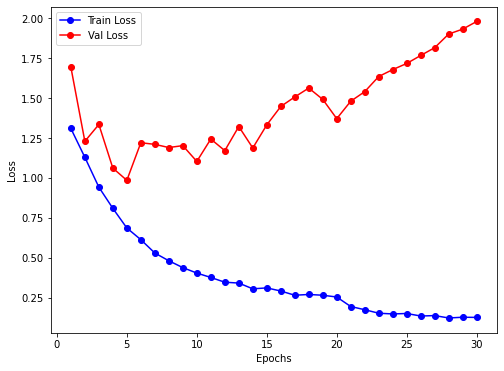

In [ ]:
plot(len(metric), metric['Train Loss'], metric['Validation Loss'], "Epochs", "Loss", "Train Loss", "Val Loss")

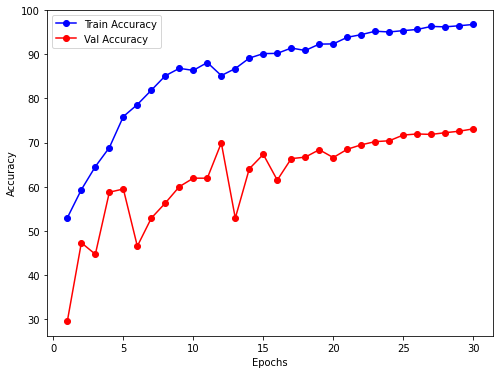

In [ ]:
plot(len(metric), metric['Train Accuracy'], metric['Validation Accuracy'], "Epochs", "Accuracy", "Train Accuracy", "Val Accuracy")

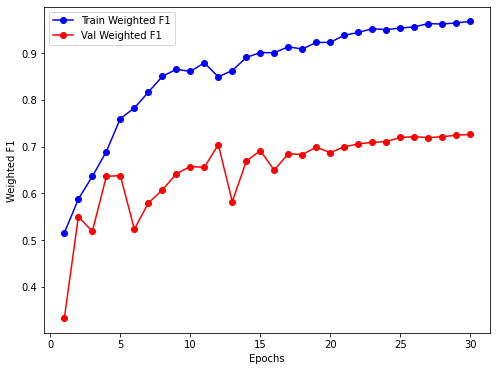

In [ ]:
plot(len(metric), metric['Train Weighted F1'], metric['Validation Weighted F1'], "Epochs", "Weighted F1", "Train Weighted F1", "Val Weighted F1")

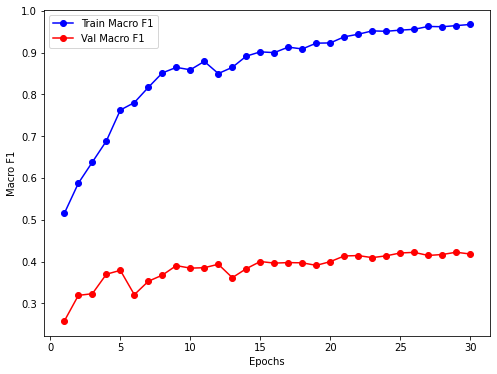

In [ ]:
plot(len(metric), metric['Train Macro F1'], metric['Validation Macro F1'], "Epochs", "Macro F1", "Train Macro F1", "Val Macro F1")

In [ ]:
import pandas as pd
results = pd.DataFrame(columns = ['Loss', 'Accuracy', 'Macro F1'], 
                   index = ['Sampled Train', 'Val', 'Test'])
results.loc['Sampled Train'] = [0.127, 96.78, 96.47]
results.loc['Val'] = [1.93, 73.10, 42.25]
results.loc['Test'] = [1.5336, 74.80, 42.64]

In [ ]:
results

,Loss,Accuracy,Macro F1
Sampled Train,0.127,96.78,96.47
Val,1.93,73.1,42.25
Test,1.5336,74.8,42.64


In [ ]:
1.364897	1.418318	43.7875	50.939759	0.429599	0.564504	0.429428	0.272566